<a href="https://colab.research.google.com/github/samans98/practice/blob/main/Oral_Cancer_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input
from keras.applications.efficientnet import EfficientNetB7
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Checking the TPUs connection
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    raise BaseException("CAN'T CONNECT TO A TPU")

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# Defining paths
train_path = '/content/drive/MyDrive/oral_cancer/train'
test_path = '/content/drive/MyDrive/oral_cancer/test'
val_path = '/content/drive/MyDrive/oral_cancer/val'

In [ ]:
# Making generators with Data Augumentation to prevent overfitting
train_gen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    preprocessing_function=preprocess_input,
)

val_gen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    preprocessing_function=preprocess_input,
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)


In [ ]:
# Reading images
train_data = train_gen.flow_from_directory(directory=train_path,target_size=(256,256), batch_size=32, class_mode='binary')
val_data = val_gen.flow_from_directory(directory=val_path, target_size=(256,256), batch_size=32, class_mode='binary')
test_data = test_gen.flow_from_directory(directory=test_path, target_size=(256,256), batch_size=32, class_mode='binary')

Found 4977 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [ ]:
# Modeling
with strategy.scope():
    model = EfficientNetB7(include_top=False, input_shape=(256,256,3))
    for layer in model.layers:
        layer.trainable = False

    final_model = Sequential([
        model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 8, 8, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2622464   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 66721176 (254.52 MB)
Trainable params: 262

In [ ]:
final_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = final_model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
156/156 [==============================] - 1437s 9s/step - loss: 0.5340 - accuracy: 0.7388 - val_loss: 0.4501 - val_accuracy: 0.7417
Epoch 2/10
156/156 [==============================] - 129s 828ms/step - loss: 0.4494 - accuracy: 0.7890 - val_loss: 0.5023 - val_accuracy: 0.8000
Epoch 3/10
156/156 [==============================] - 129s 826ms/step - loss: 0.4227 - accuracy: 0.8055 - val_loss: 0.4419 - val_accuracy: 0.8000
Epoch 4/10
156/156 [==============================] - 132s 846ms/step - loss: 0.4057 - accuracy: 0.8137 - val_loss: 0.4634 - val_accuracy: 0.7417
Epoch 5/10
156/156 [==============================] - 133s 851ms/step - loss: 0.3806 - accuracy: 0.8250 - val_loss: 0.3892 - val_accuracy: 0.8083
Epoch 6/10
156/156 [==============================] - 130s 834ms/step - loss: 0.3561 - accuracy: 0.8405 - val_loss: 0.4705 - val_accuracy: 0.7667
Epoch 7/10
156/156 [==============================] - 132s 847ms/step - loss: 0.3474 - accuracy: 0.8437 - val_loss: 0.4210 - v

In [ ]:
# Model performance on testing set
final_model.evaluate(test_data)

4/4 [==============================] - 39s 12s/step - loss: 0.3065 - accuracy: 0.8651


[0.3064938485622406, 0.8650793433189392]

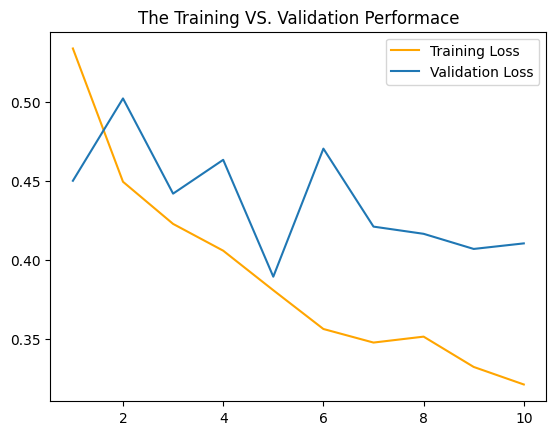

In [ ]:
plt.plot(range(1,11), history.history['loss'], 'orange', label='Training Loss')
plt.plot(range(1,11), history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("The Training VS. Validation Performace")
plt.show()

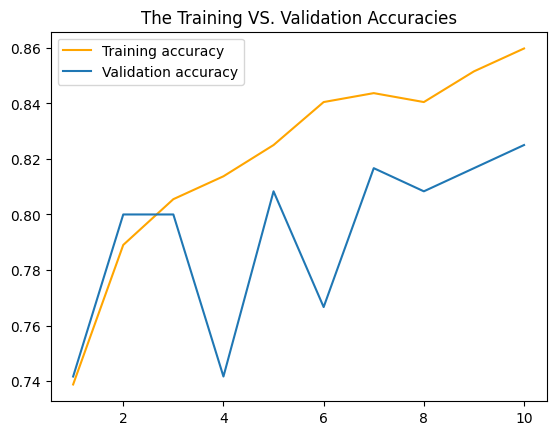

In [ ]:
plt.plot(range(1,11), history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(range(1,11), history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title("The Training VS. Validation Accuracies")
plt.show()

In [ ]:
# Prediction Function
def predict(img, model):
    predicted_img = img.reshape(1,img.shape[0], img.shape[1], 3)
    prediction1 = model.predict(predicted_img)
    mapping = {0:'Normal', 1:'OSCC'}
    prediction1 = prediction1[0][0].round()
    return mapping[prediction1]

In [ ]:
# We will test on 2 images (Normal and OSCC) from testing set
imgNormal_path = '/content/drive/MyDrive/oral_cancer/test/Normal/Normal_100x_12.jpg'
imgOSCC_path = '/content/drive/MyDrive/oral_cancer/test/OSCC/OSCC_400x_110.jpg'

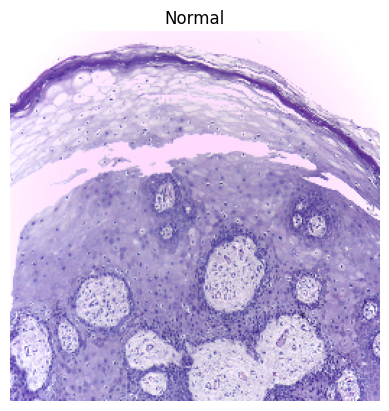

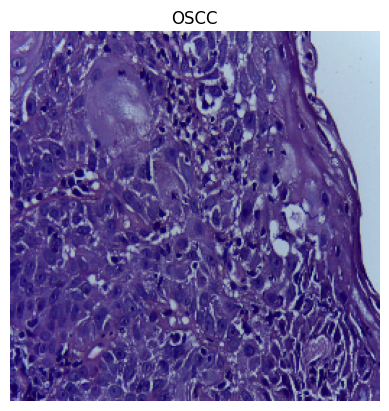

In [ ]:
# reading the images
imgNormal = cv.imread(imgNormal_path)
imgOSCC = cv.imread(imgOSCC_path)

# convert images to rgb instead of BGR
imgNormal = cv.cvtColor(imgNormal, cv.COLOR_BGR2RGB)
imgOSCC = cv.cvtColor(imgOSCC, cv.COLOR_BGR2RGB)

# Resizing both images to 256 x 256
imgNormal = cv.resize(imgNormal, (256,256))
imgOSCC = cv.resize(imgOSCC, (256,256))

# Displaying the images before prediction
plt.imshow(imgNormal, cmap='gray')
plt.axis(False)
plt.title("Normal")
plt.show()

plt.imshow(imgOSCC, cmap='gray')
plt.axis(False)
plt.title("OSCC")
plt.show()

1/1 [==============================] - 0s 454ms/step


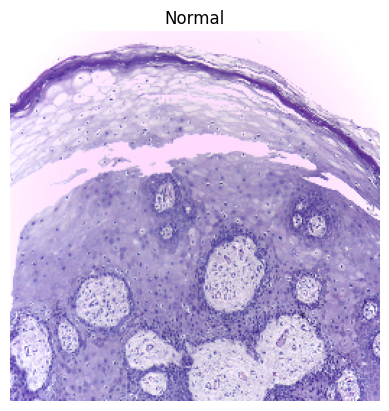

1/1 [==============================] - 0s 458ms/step


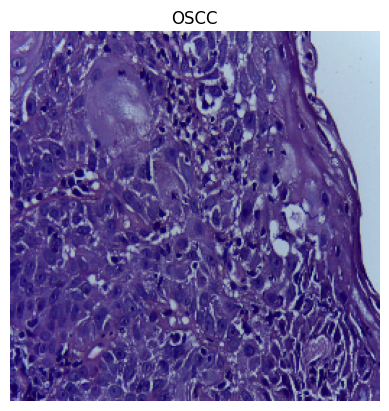

In [ ]:
plt.imshow(imgNormal)
plt.title(predict(imgNormal,final_model)) # Displaying the prediction
plt.axis(False)
plt.show()

plt.imshow(imgOSCC)
plt.title(predict(imgOSCC,final_model)) # Displaying the prediction
plt.axis(False)
plt.show()